In [1]:
# ssh variables

import os
from sshtunnel import SSHTunnelForwarder
import pg as db
import pandas as pd
import re 
from sqlalchemy import create_engine
import numpy as np
import plotly.express as px
%matplotlib inline

host = 'prd-db.spot-internal'
localhost = '127.0.0.1'
ssh_username = os.environ['SPOT_SSH_USER']
ssh_private_key = '/Users/david/.ssh/id_rsa'
ssh_private_key_pwd = os.environ['SSH_PWD']

intermediary=os.environ['SPOT_SSH_SERVER']
user=os.environ['SPOT_DB_USER']
password=os.environ['SPOT_DB_PW']

database='trace_wood_delawareconnector'

def query(q):
    with SSHTunnelForwarder(
    (intermediary, 22), 
    ssh_username=ssh_username,
    ssh_pkey=ssh_private_key, 
    ssh_private_key_password=ssh_private_key_pwd,
    remote_bind_address=(host,5432)) as server:

        connstring = 'postgresql://{user}:{pwd}@{host}:{localport}/{database}'.format(
            user=user,
            pwd=password,
            host=localhost,
            localport=server.local_bind_port,
            database=database)
        
        engine = create_engine(connstring)

        try:
            result = pd.read_sql_query(q, engine)
        finally:
            engine.dispose()

        return result;

## Create a table of the desired transitions from the original email.

In [2]:
desired_transitions = pd.DataFrame([
    ['Wood General','Wood Approved','Sr. Approved',35],
    ['Wood General','Chief Approved','Sr. Approved',477],
    ['Wood General','Approved','Sr. Approved',467],
    ['Wood General','Exxon Approved','Sr. Approved',25],
    ['Wood Daily Construction Report','Approved','Chief Approved',127],
    ['Exxon Workflow','Sr. Approved','Sr Approved',3],
    ['Exxon Workflow','Chief Approved','Sr Approved',2]
], columns=['workflow_name','status_name','desired_status','form_count'])

In [3]:
desired_transitions

,workflow_name,status_name,desired_status,form_count
0,Wood General,Wood Approved,Sr. Approved,35
1,Wood General,Chief Approved,Sr. Approved,477
2,Wood General,Approved,Sr. Approved,467
3,Wood General,Exxon Approved,Sr. Approved,25
4,Wood Daily Construction Report,Approved,Chief Approved,127
5,Exxon Workflow,Sr. Approved,Sr Approved,3
6,Exxon Workflow,Chief Approved,Sr Approved,2


## Grab the workflow statuses from the database

In [4]:
statuses = query('select * from dynamic_workflow_status')
statuses.head()

,id,name,created_at,updated_at,deleted_at
0,be8f911e-d496-4ed7-94b8-49bd5fa16e93,Pending,2019-02-07 16:30:29.189000+00:00,2019-02-07 16:30:29.189000+00:00,None
1,e7b7c5cf-a43d-4940-bf1d-1e0da7531a8e,Submitted,2019-02-07 16:30:29.198000+00:00,2019-02-07 16:30:29.198000+00:00,None
2,0c0854e7-85a8-4c26-b034-808f3bc2db0b,Re-Submitted,2019-02-07 16:30:29.216000+00:00,2019-02-07 16:30:29.216000+00:00,None
3,996356d1-1d09-477a-98fc-d3189b5f4a7e,Wood Rejected,2019-02-07 16:30:29.208000+00:00,2019-03-12 15:56:45.083000+00:00,None
4,5e299e51-e408-46a4-9df0-37cdbdc478e4,Wood Approved,2019-02-07 16:30:29.223000+00:00,2019-03-12 15:56:53.446000+00:00,None


## Grab the workflows from the database

In [5]:
workflows = query('select id, name from dynamic_workflow') \
[lambda x:x['name'].apply(lambda y:not ('DO NOT USE' in y))]
workflows

,id,name
0,e53175b7-1633-4155-8399-72d3ebc25f79,Wood Daily Construction Report
1,88ac6388-5e5f-4a06-8df7-5d3f220e34b2,Exxon Workflow II
3,5d4bfdfc-0b8b-41d1-8bdb-fce72df0cb8c,Wood General
9,9334b10f-b906-493e-896f-f69b89da5ad7,Exxon Workflow


## Grab the types from the database

In [8]:
types = query('select id, table_name, workflow_id, workflow_enabled from dynamic_type_definition where workflow_enabled = true')
types.head()

,id,table_name,workflow_id,workflow_enabled
0,248b9d96-3e27-4ba0-8da4-29cc4ad3e24a,_daily_inspection_report_and_summary_of_pipe_w...,88ac6388-5e5f-4a06-8df7-5d3f220e34b2,True
1,9f83f4e3-fe2c-4203-9d57-e55adbcf1740,_jeeping_daily_report,9334b10f-b906-493e-896f-f69b89da5ad7,True
2,29f42027-0ae7-415f-874c-1e52a65fcdea,_hvac0102_hvac_packaged_system_installation,9334b10f-b906-493e-896f-f69b89da5ad7,True
3,52209cfd-fa61-4314-aa45-7b81b59df121,_weld_inspection_log,5d4bfdfc-0b8b-41d1-8bdb-fce72df0cb8c,True
4,9665e86a-8e91-4523-bd03-f39f92d4a9fa,_inst0710_check_report_of_orifice_plate,9334b10f-b906-493e-896f-f69b89da5ad7,True


## Get the dynamics from the database (this one takes a second to run)

In [9]:
db_dynamics = query('select id, type, status_id, deleted_at, updated_at, created_at from dynamic')

In [81]:
db_dynamics[[(not (y is None)) for y in db_dynamics['status_id']]]

,id,type,status_id,deleted_at,updated_at,created_at
14202,042750bb-5118-46c2-90c8-c9765f465126,_electrical_report,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,NaT,2019-07-17 20:44:45.116000+00:00,2019-07-17 20:41:44.154000+00:00
14203,488de12f-d77e-4c7f-9081-3e064465cc7c,_electrical_report,ce0c92d1-86e3-4263-97f3-31abe69b6353,NaT,2019-05-18 15:52:23.967000+00:00,2019-05-16 12:39:59.081000+00:00
14204,3dbebd4d-4186-4e03-bf97-3e0784b52e6b,_electrical_report,e7b7c5cf-a43d-4940-bf1d-1e0da7531a8e,2019-06-05 23:30:37.592000+00:00,2019-06-05 23:30:37.562000+00:00,2019-01-24 18:48:43.921000+00:00
14205,7dd9e0f6-61e2-4cec-8fa6-ccde3cdb2664,_electrical_report,be8f911e-d496-4ed7-94b8-49bd5fa16e93,2019-04-27 20:03:09.355000+00:00,2019-04-27 20:03:09.339000+00:00,2019-04-27 16:42:53.691000+00:00
14206,ea657238-67d2-4f91-8331-9ee6505201e0,_electrical_report,6d97d243-3062-4a65-9b73-ce3c53471770,NaT,2019-02-18 14:19:12.155000+00:00,2019-02-18 14:16:03.442000+00:00
14207,828621a2-fcdc-4ea4-a270-9ad5ea0f032c,_electrical_report,be8f911e-d496-4ed7-94b8-49bd5fa16e93,2019-04-05 21:41:17.902000+00:00,2019-04-05 21:41:17.854000+00:00,2019-04-05 21:40:46.700000+00:00
14208,cc8e626b-dcbf-431d-8705-68744bf3ca84,_electrical_report,be8f911e-d496-4ed7-94b8-49bd5fa16e93,2019-04-27 20:06:00.285000+00:00,2019-04-27 20:06:00.243000+00:00,2019-02-05 16:09:33.186000+00:00
14209,de667539-7295-4c31-b34e-9fe1697b3653,_electrical_report,be8f911e-d496-4ed7-94b8-49bd5fa16e93,2019-04-27 19:56:13.359000+00:00,2019-04-27 19:56:13.320000+00:00,2019-04-24 19:13:13.468000+00:00
14210,6107a9c5-7e45-4323-9b12-e01cee9bbd5f,_electrical_report,be8f911e-d496-4ed7-94b8-49bd5fa16e93,2019-04-27 20:04:08.298000+00:00,2019-04-27 20:04:08.270000+00:00,2019-04-27 15:54:19.412000+00:00
14211,4e3f8e70-edd8-4a45-b7eb-b396e879e99a,_electrical_report,be8f911e-d496-4ed7-94b8-49bd5fa16e93,2019-06-21 22:22:15.119000+00:00,2019-06-21 22:22:15.091000+00:00,2019-06-21 22:12:22.406000+00:00


In [10]:
dynamics = db_dynamics \
[lambda x:(x['status_id'].apply(lambda y:not (y is None)))] \
[lambda x:(x['deleted_at'].apply(np.isnat))] \
.merge(statuses[['id','name']].rename(columns={'id':'status_id', 'name':'status_name'}), on='status_id') \
.merge(types[['table_name','workflow_id']].rename(columns={'table_name':'type'}), on='type') \
.merge(workflows[['id','name']].rename(columns={'id':'workflow_id','name':'workflow_name'}), on='workflow_id') \
.merge(desired_transitions, on=['workflow_name','status_name']) \
.merge(statuses[['id','name']].rename(columns={'name':'desired_status','id':'desired_status_id'}), on='desired_status') \
[['id','type','status_id','status_name','workflow_name','desired_status','desired_status_id','updated_at','created_at']]

dynamics

,id,type,status_id,status_name,workflow_name,desired_status,desired_status_id,updated_at,created_at


# Final count of items that will need changing

In [11]:
# Number of target statuses... I think there might only be one of them.
dynamics['desired_status_id'].value_counts()

Series([], Name: desired_status_id, dtype: int64)

# Final list of items that will need changing

In [12]:
# this is the list of items.
dynamics['id'].astype('str').tolist()

[]

In [13]:
dynamics['updated_at'].describe()

count     0
unique    0
Name: updated_at, dtype: int64

In [85]:
import seaborn as sns

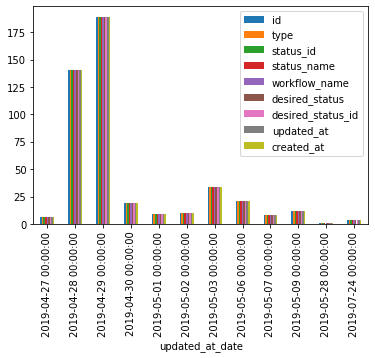

In [117]:
dynamics.groupby('updated_at_date').count().plot(kind='bar')

In [93]:
dynamics

,id,type,status_id,status_name,workflow_name,desired_status,desired_status_id,updated_at,created_at,updated_at_date
0,3ec2df2b-284c-4fd1-a1b2-2b972b51fcda,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-04-29 18:15:10.023000+00:00,2019-04-05 19:42:52.070000+00:00,2019-04-29
1,41a2aec0-180a-4481-b8cb-cc88d213cee5,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-04-28 23:11:34.128000+00:00,2019-02-15 20:30:36.277000+00:00,2019-04-28
2,1ba873c7-8bc5-49e2-aeee-af5c5ed40fd7,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-05-07 23:12:22.008000+00:00,2019-05-04 13:16:38.181000+00:00,2019-05-07
3,89d91f7e-c70e-4195-a539-1b1733921ea8,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-04-27 22:07:16.462000+00:00,2019-04-20 15:33:52.298000+00:00,2019-04-27
4,ad7874a2-e3de-45e0-a407-fb495977ce46,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-04-28 23:16:15.664000+00:00,2019-02-12 22:27:00.096000+00:00,2019-04-28
5,eb0abf8e-f79d-41a9-b5a6-76e4c98bffe9,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-05-09 19:07:51.814000+00:00,2019-05-09 12:29:36.618000+00:00,2019-05-09
6,61b2d6c5-1be8-4ef2-b79e-fb6f926a7adc,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-04-28 22:16:19.876000+00:00,2019-02-23 14:34:23.190000+00:00,2019-04-28
7,84730057-54ad-481e-9840-ba3628164c68,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-04-28 18:05:52.001000+00:00,2019-01-24 14:24:05.680000+00:00,2019-04-28
8,48d67393-d17b-4ce6-ad54-2b3e9b9fcaed,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-04-28 18:14:48.712000+00:00,2019-01-25 22:27:45.775000+00:00,2019-04-28
9,6c3ece84-b0ba-4436-a85d-abb989dade89,_facility_daily_progress_report,6d97d243-3062-4a65-9b73-ce3c53471770,Approved,Wood General,Sr. Approved,fcf8c015-515d-4f9f-b591-2a2e49b21d5b,2019-04-28 19:11:32.282000+00:00,2019-01-29 12:29:40.497000+00:00,2019-04-28


TypeError: unsupported operand type(s) for +: 'datetime.date' and 'datetime.date'

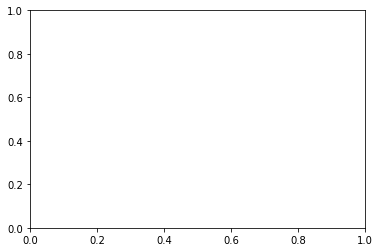

In [95]:
sns.distplot(dynamics['updated_at_date'], kde=False)